<a href="https://colab.research.google.com/github/GuysBarash/Genetic-programing-with-DEAP/blob/master/GP_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
from __future__ import print_function
import sys
colab_mode = 'google.colab' in sys.modules
if colab_mode:
  from google.colab import drive

  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
if colab_mode:
  !apt install libgraphviz-dev
  !pip install pygraphviz
  import pygraphviz as pgv
  !pip install DEAP
  !pip install dill
  import pygraphviz as pgv
  pass

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [0]:
import os
import random
import operator
import numpy as np
import pandas as pd
from datetime import datetime
import tqdm

import dill
import pickle

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap.tools import History
from deap.algorithms import varAnd

from IPython.display import display
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score

# Generate Data

Fetch data

In [133]:
if not colab_mode:
  train_set = r"C:\school\evolutionary\ex2\train.csv"
  vld_set = r"C:\school\evolutionary\ex2\validate.csv"
  test_set = r"C:\school\evolutionary\ex2\test.csv"
  print("loading trains set.")
  rawdatadf = pd.read_csv(train_set, header=None)
  print("loading VLD set.")
  rawvlddf = pd.read_csv(vld_set, header=None)
  print("loading test set.")
  rawtestdf = pd.read_csv(test_set, header=None)
else:

  base_folder = r'/content/drive/My Drive/colab_storage'
  train_set = os.path.join(base_folder ,'train.csv')
  vld_set = os.path.join(base_folder ,'validate.csv')
  test_set = os.path.join(base_folder ,'test.csv')
  print("Loading train set..")
  rawdatadf = pd.read_csv(train_set, header=None)
  print("Loading validation set.")
  rawvlddf = pd.read_csv(vld_set, header=None)
  print("Loading test set.")
  rawtestdf = pd.read_csv(test_set, header=None)

Loading train set..
Loading validation set.
Loading test set.


Choose only last n tuples

In [0]:
last_n_samples = 15

def get_last_n_tuples_from_cols(n, cols):
    return cols[-4 * n:]


datacols = (rawdatadf.columns[1:])
datacols = get_last_n_tuples_from_cols(last_n_samples, datacols)
datadf = pd.DataFrame(columns=datacols, index=range(rawdatadf.shape[0]), data=rawdatadf[datacols])
vld_df = pd.DataFrame(columns=datacols, index=range(rawvlddf.shape[0]), data=rawvlddf[datacols])
test_df = pd.DataFrame(columns=datacols, index=range(rawtestdf.shape[0]), data=rawtestdf[datacols])

Normalize data

In [0]:
ldf = datadf.copy()
mean_of_df = ldf.mean(axis=0)
std_of_df = ldf.std(axis=0)
ldf -= mean_of_df
ldf /= std_of_df
normal = pd.Series(index=ldf.columns, data=np.fmax(-ldf.min(axis=0), ldf.max(axis=0)))
ldf /= normal

def normalize(dataset):
  dataset -= mean_of_df
  dataset /= std_of_df
  # dataset /= normal
  return dataset

datadf = normalize(datadf)
vld_df = normalize(vld_df)
test_df = normalize(test_df)

labels = rawdatadf[rawdatadf.columns[0]]
vld_labels = rawvlddf[rawvlddf.columns[0]]
test_labels = rawtestdf[rawtestdf.columns[0]]
labelcol = 'LABEL'
datadf[labelcol] = labels
vld_df[labelcol] = vld_labels
datadf[labelcol] = labels
test_df[labelcol] = test_labels

Display

In [136]:
top_n = 10
print("Train set.")
display(datadf.head(top_n))
print(f"\nTrain Set: Displaying top {top_n} out of {len(datadf)}.")
print("\n\n")

print("Validation set.")
display(vld_df.head(top_n))
print(f"\nValidation Set: Displaying top {top_n} out of {len(vld_df)}.")
print("\n\n")

print("test set.")
display(test_df.head(top_n))
print(f"\Test Set: Displaying top {top_n} out of {len(test_df)}.")
print("\n\n")

Train set.


,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,LABEL
0,-0.248169,0.202263,-0.206282,0.100839,-0.265536,-0.009414,-0.181163,-0.098034,-0.286586,-0.091397,-0.219836,-0.113604,-0.274193,-0.205130,-0.207095,-0.235586,-0.276004,-0.352937,-0.237558,-0.425218,-0.262857,-0.409356,-0.211709,-0.458746,-0.269982,-0.399023,-0.218087,-0.504852,-0.270390,-0.442526,-0.246016,-0.527583,-0.262284,-0.617992,-0.230629,-0.589942,-0.263195,-0.613349,-0.191868,-0.687470,-0.260712,-0.605379,-0.227365,-0.683877,-0.246745,-0.497117,-0.230752,-0.580024,-0.254504,-0.408814,-0.219757,-0.474134,-0.248822,-0.417031,-0.204508,-0.499808,-0.279900,-0.386771,-0.228900,-0.442452,0
1,4.852536,-1.448564,1.759035,-0.998635,0.690698,-0.881389,0.060755,-0.604549,0.294773,-0.852712,0.004394,-0.585289,2.307566,-1.281192,2.270720,-0.794392,1.742275,-1.265089,0.027156,-1.012594,6.612257,-0.743680,1.598865,-0.398738,4.439195,-0.181375,3.348749,0.241466,3.125881,-0.721651,2.524626,-0.320293,1.000405,-0.728282,0.141599,-0.498402,1.022858,-0.712147,-0.028022,-0.487476,2.347735,-0.387373,1.471718,-0.078838,4.154610,-0.548425,3.222509,-0.206364,3.003875,-0.822811,2.931732,-0.440212,1.216025,-1.033214,0.107590,-0.826459,1.784861,-1.360739,2.968299,-1.075357,1
2,-0.147871,0.250184,-0.171197,0.111609,-0.231146,0.333827,-0.164430,0.193818,-0.234175,0.281139,-0.157553,0.156228,-0.011748,0.184992,-0.053809,0.080471,-0.173218,0.143037,-0.198620,0.052741,-0.123443,0.146056,-0.171380,0.040379,-0.124086,0.156795,-0.174644,0.048990,-0.102660,0.148391,-0.150688,0.035394,-0.144052,0.137342,-0.153264,0.024995,-0.096326,0.150709,-0.140177,0.044191,-0.195857,0.217815,-0.177286,0.103374,-0.185647,0.268144,-0.181190,0.150654,0.013111,0.254909,0.078888,0.173648,0.028358,0.181885,-0.009053,0.097599,-0.272379,0.168881,-0.222979,0.054121,1
3,-0.118918,-0.863534,-0.127014,-0.701159,1.671249,-1.165909,1.837623,-0.854622,-0.224822,-1.176296,-0.177259,-1.026183,-0.248117,-1.143135,-0.191823,-0.995978,-0.160560,-1.111989,-0.134420,-0.968693,-0.204428,-1.082655,-0.171662,-0.943146,-0.235708,-1.055189,-0.198577,-0.919217,-0.252478,-1.029792,-0.233402,-0.896786,1.209716,-1.249752,3.118671,-1.050193,-0.159373,-1.293833,0.003414,-1.168022,-0.270190,-1.266741,-0.211988,-1.143636,1.801898,-1.142591,3.421359,-1.016324,-0.152533,-1.216677,0.209273,-1.098261,-0.228758,-1.194511,-0.136295,-1.078080,-0.202451,-1.173902,-0.080704,-1.059047,0
4,-0.241641,0.201979,-0.131790,0.126031,-0.262782,0.195727,-0.128211,0.122355,-0.236916,0.190495,-0.129666,0.119750,-0.223042,0.185422,-0.087520,0.116844,-0.210581,0.180840,-0.099281,0.113766,2.052229,0.194761,0.909034,0.213736,-0.148467,0.173546,-0.186883,0.110049,0.390113,0.238390,0.065789,0.215536,0.920336,0.320882,0.763274,0.327135,-0.163436,0.284259,-0.180888,0.224863,-0.070850,0.278643,-0.190424,0.220364,0.905171,0.314463,0.148445,0.330324,-0.077432,0.383040,-0.157782,0.327350,-0.106522,0.376581,-0.153525,0.322032,1.089682,0.405219,0.090761,0.406408,0
5,-0.272975,2.545503,-0.210433,2.588389,-0.280803,2.642384,-0.205657,2.602798,-0.286908,2.640591,-0.222105,2.621066,-0.271808,2.313841,-0.209471,2.346201,-0.275470,1.755421,-0.238381,2.160831,-0.262347,1.701749,-0.214420,2.211506,-0.281822,2.051843,-0.228266,2.129870,-0.271589,1.754313,-0.247528,1.927721,-0.256413,1.403824,-0.237708,1.654449,-0.259422,1.202399,-0.195728,1.336446,-0.272653,1.194587,-0.228248,1.192889,-0.248307,0.933392,-0.233515,1.014504,-0.254300,1.038689,-0.219193,1.353953,-0.258098,1.414183,-0.212390,1.433730,-0.280198,1.221774,-0.229788,1.238415,0
6,-0.263529,-0.892249,-0.206850,-0.907115,-0.276632,-0.719296,-0.192557,-0.693602,-0.286667,-0.670759,-0.221747,-0.677218,-0.271578,-0.544271,-0.200477,-0.615243,-0.272191,-0.481923,-0.231479,-0.601787,-0.260164,-0.492652,-0.208207,-0.592752,-0.270371,-0.469768,-0.222692,-0.470093,-0.254052,-0.444663,-0.245688


Train Set: Displaying top 10 out of 700000.



Validation set.


,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,LABEL
0,-0.023381,-1.403671,-0.132359,-1.494190,-0.103895,-1.317080,-0.079332,-1.423804,-0.130562,-1.190326,-0.127636,-1.310856,-0.150431,-1.002539,-0.162580,-1.099274,-0.037187,-0.550204,-0.156960,-0.588189,0.139811,-0.334504,-0.075979,-0.572831,-0.159138,-0.439011,-0.164404,-0.554697,-0.113677,-0.404538,-0.154564,-0.537009,-0.082183,-0.310613,-0.178196,-0.426159,-0.133980,-0.201933,-0.127141,-0.300140,-0.124510,-0.270844,-0.132215,-0.395102,-0.170168,-0.324027,-0.161004,-0.416032,-0.157499,-0.581019,-0.147170,-0.656045,-0.146786,-0.622677,-0.128957,-0.699047,-0.190536,-0.551607,-0.172830,-0.625921,1
1,-0.127749,-0.696971,-0.128833,-0.738925,-0.216509,-0.755261,-0.191401,-0.834145,0.106255,-0.710328,-0.058844,-0.819177,-0.040054,-0.885950,-0.123891,-0.985623,-0.018658,-0.898269,-0.049770,-0.921056,0.049804,-0.932176,0.200111,-0.983929,-0.207277,-1.090442,-0.158284,-1.111693,0.032768,-0.930976,-0.009896,-0.989642,-0.112640,-1.128455,0.017941,-1.170470,0.222757,-1.433546,0.124493,-1.449920,0.069532,-1.531285,-0.020157,-1.601900,0.129012,-1.521445,0.127659,-1.531406,-0.034099,-1.407965,-0.108393,-1.433173,-0.250334,-1.329927,-0.204128,-1.391445,-0.208409,-1.407102,-0.116110,-1.465881,0
2,0.545771,0.821305,0.140131,0.927555,0.106459,1.054540,-0.092763,0.983756,0.238814,0.632961,0.168670,0.551002,0.106321,0.942563,-0.018230,0.882846,0.408270,-0.023167,0.231088,0.084723,0.310731,-0.434035,0.180568,-0.503210,0.024692,-0.097220,-0.004567,-0.149153,0.046783,-0.461249,0.000879,-0.484894,0.161988,-0.668203,0.170916,-0.628233,0.061619,-0.943641,0.025022,-0.915647,0.178420,-1.140286,-0.001304,-1.180530,0.111090,-1.311370,0.122732,-1.369771,0.137870,-1.156770,-0.085590,-1.219968,-0.059386,-0.973384,-0.077810,-0.994998,0.267754,-0.937631,-0.026588,-1.024330,1
3,-0.140575,-0.292460,-0.082888,-0.339302,-0.107830,-0.274192,-0.056984,-0.349436,-0.282474,-0.337305,-0.219418,-0.440931,-0.060745,-0.446784,-0.085597,-0.478033,-0.177031,-0.279213,-0.138599,-0.318067,0.002145,-0.609314,-0.112072,-0.662823,-0.155555,-0.657653,-0.168282,-0.722670,-0.064063,-0.465327,-0.070535,-0.521040,-0.174656,-0.565427,-0.193293,-0.620087,-0.177874,-0.556061,-0.106335,-0.629170,-0.233099,-0.621158,-0.187537,-0.663899,-0.199767,-0.582879,-0.190862,-0.634165,-0.057228,-0.555854,-0.077349,-0.621983,-0.118615,-0.607299,-0.109281,-0.684730,-0.162461,-0.599624,-0.187987,-0.678810,0
4,-0.272130,0.880201,-0.211229,0.950850,-0.279465,1.026572,-0.204667,1.216971,-0.287231,0.965973,-0.222403,0.971991,-0.278423,0.695833,-0.212469,0.728852,-0.271124,0.374172,-0.232872,0.628156,-0.258418,0.708607,-0.210579,0.805061,-0.280030,0.920751,-0.223419,0.984911,-0.272414,0.750184,-0.248513,0.871603,-0.268082,0.777414,-0.236643,0.900432,-0.271030,0.763137,-0.195377,0.892863,-0.276907,0.646046,-0.227718,0.798316,-0.251362,0.881052,-0.232614,0.932222,-0.256477,0.814722,-0.220547,0.817294,-0.257273,0.549652,-0.212770,0.638770,-0.273123,0.559393,-0.227064,0.697685,0
5,-0.265372,0.339686,-0.206111,0.595018,-0.268920,0.002239,-0.199713,0.272473,-0.282312,-0.328010,-0.219418,-0.111249,-0.262194,-0.426262,-0.194029,-0.440192,-0.261593,0.158819,-0.225655,0.229185,-0.252888,-0.096080,-0.209958,-0.040941,-0.263439,-0.345108,-0.219057,-0.175452,-0.262221,-0.608191,-0.236227,-0.304129,-0.265440,-0.559393,-0.235578,-0.511152,-0.259857,-0.196698,-0.164393,-0.225943,-0.265787,-0.329345,-0.216583,-0.240306,-0.244709,-0.498044,-0.230572,-0.459245,-0.236817,-0.401964,-0.209879,-0.387155,-0.242157,-0.200401,-0.203965,-0.198110,-0.261878,0.057494,-0.219841,0.181486,1
6,-0.141420,0.430371,-0.124739,0.305940,-0.203209,0.465302,-0.159861,0.310999,-0.108953,0.409006,-0.096584,0.263486,0.099860,0.466226,-0.059578,0.365807,-0.144548,0.530999,-0.135180,0.397402,0.300835,0.415115,0.251398,0.304054,-0.084126,0.531213,-0.


Validation Set: Displaying top 10 out of 50000.



test set.


,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,LABEL
0,0.292721,0.076477,-0.093294,0.032329,-0.266795,0.187958,-0.200703,0.098901,-0.012597,0.069267,-0.060218,0.097001,-0.261655,0.178108,-0.205003,0.094753,-0.112446,0.263733,-0.170002,0.257515,-0.196570,0.330269,-0.142969,0.283233,-0.092305,0.475229,-0.081456,0.417380,0.030595,0.585296,-0.126773,0.520823,-0.139722,0.464381,-0.106281,0.412928,-0.222638,0.489355,-0.135163,0.382118,-0.239890,0.398008,-0.187773,0.340416,-0.211919,0.192110,-0.133790,0.188009,-0.213348,0.220342,-0.199945,0.159560,-0.170285,0.292552,-0.134664,0.248035,-0.230377,0.267243,-0.163476,0.190318,?
1,-0.139730,2.467402,-0.116892,2.477559,-0.250584,2.305767,-0.188043,2.287263,-0.192972,1.978109,-0.182753,1.962813,-0.132817,2.065992,-0.145724,2.041708,-0.225145,1.999116,-0.211536,1.943760,-0.179907,1.589696,-0.154999,1.620466,-0.158905,1.334599,-0.142531,1.367668,-0.144330,1.427061,-0.007859,1.364705,-0.124823,1.020805,-0.043074,1.007082,-0.231490,0.884546,-0.116713,0.855038,-0.203097,0.728870,-0.110416,0.769916,-0.155029,0.665847,-0.167793,0.621202,-0.199063,0.575691,-0.189729,0.546652,-0.167125,0.523942,-0.144448,0.509224,-0.135800,0.612842,-0.150746,0.588151,?
2,-0.200324,0.617371,-0.134747,0.556256,-0.084929,0.473940,-0.159145,0.443525,-0.006711,0.724490,0.200319,0.728995,-0.108665,0.892701,0.154118,0.822698,-0.194949,0.860977,-0.089341,0.835196,-0.217962,0.820987,-0.158050,0.725746,-0.203850,0.775519,-0.094543,0.708988,-0.170561,0.799553,-0.117247,0.752729,-0.152638,0.782538,0.047133,0.761313,-0.136447,0.707631,0.100879,0.659362,-0.093090,0.676478,-0.045373,0.635608,-0.242197,0.719719,-0.188879,0.635880,0.073994,0.773795,0.129857,0.721976,-0.153932,0.741911,-0.077212,0.744946,-0.211537,0.684547,-0.180883,0.664727,?
3,-0.170680,-1.601030,-0.119963,-1.642643,-0.233586,-1.215492,-0.177695,-1.269976,-0.181441,-1.178996,-0.159464,-1.273134,-0.222581,-1.165205,-0.175533,-1.268585,-0.235896,-1.308377,-0.184881,-1.417063,-0.135377,-1.297665,-0.125289,-1.400835,-0.199254,-1.407006,-0.153619,-1.538828,-0.183227,-1.367803,-0.162119,-1.460231,-0.178105,-1.052854,-0.148503,-1.165256,-0.181864,-0.729894,-0.114858,-0.814347,-0.190633,-0.583709,-0.161732,-0.671008,-0.177025,-0.749948,-0.149470,-0.853725,-0.171512,-0.630335,-0.148355,-0.705282,-0.157849,-0.471781,-0.166733,-0.564099,-0.208632,-0.541417,-0.170462,-0.632452,?
4,-0.192567,0.065502,-0.180693,0.038212,-0.275767,0.121101,-0.201529,0.042738,-0.227563,0.152165,-0.151104,0.160582,-0.251656,0.210805,-0.191484,0.150759,-0.212335,0.301537,-0.204445,0.284460,-0.263584,0.368368,-0.213686,0.299473,-0.262426,0.360198,-0.220874,0.293107,-0.273463,0.351928,-0.249367,0.286425,-0.271972,0.344299,-0.241654,0.280166,-0.173231,0.142281,-0.100770,0.128328,-0.207948,0.153788,-0.149006,0.113071,-0.194336,0.143332,-0.172238,0.104085,-0.180696,0.228276,-0.144912,0.174980,-0.129677,0.297941,-0.031066,0.283967,-0.253314,0.096602,-0.199592,0.078179,?
5,0.046659,0.998134,0.116760,0.973861,0.060816,0.969358,0.009344,0.911560,-0.019209,1.214802,-0.048036,1.136432,0.244082,1.774863,0.143767,1.757882,0.143070,1.834085,0.178665,1.825110,-0.205811,1.520229,-0.112863,1.473739,-0.144105,1.206757,0.002098,1.197381,-0.190122,1.116162,-0.108444,1.074180,-0.074551,1.405911,0.061541,1.396842,-0.102202,1.462964,-0.029777,1.393890,-0.195335,1.333731,-0.134454,1.299562,-0.113821,1.106091,-0.151572,1.078287,0.033859,1.239205,-0.070181,1.260386,-0.110301,1.248286,-0.079876,1.224097,-0.077639,1.287000,0.005502,1.228264,?
6,0.218457,0.405016,0.097483,0.348498,0.253070,0.296766,0.095432,0.246636,0.386614,0.187795,-0.036989,0.202526,0.331461,0.215366,0.795943,0.212288,0.665997,0.428429,0.219312,0.362693,0.506389,0.947480,0.014055,0.805061,0.152828,1.096619,-0.015412,1.061215,0.040787,1.272116,0.337716,1.298569,0.322274,1.437184,0.689793,1.412219,0.267666,1

\Test Set: Displaying top 10 out of 50000.





Data folding. 


*   Sample: an entry from the data
*   event: number of items in each sample (15 as defualt) 
*   feature: number of measuring at each event (4 at defualt) 

After folding:                                           
X = (#samples x events x features).                
y = [#is_label_0, is_label_1]

In [137]:
def fold_data(dataset, features=4):
    entries_per_sample = int(len(datacols) / features)
    samples = dataset.shape[0]
    X = np.zeros((samples, entries_per_sample, features))
    for pos in range(entries_per_sample):
        entry = dataset[datacols[features * pos:features * pos + features]]
        X[:, pos, :] = entry
    y = pd.get_dummies(dataset[labelcol])
    return X, y

number_of_features = 4
window_size = int(len(datacols) / number_of_features)
X , y =  fold_data(datadf, number_of_features)

print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"Example of a single sample:")
display(pd.DataFrame(data=X[0,:,:]))

X: (700000, 15, 4)
y: (700000, 2)
Example of a single sample:


,0,1,2,3
0,-0.248169,0.202263,-0.206282,0.100839
1,-0.265536,-0.009414,-0.181163,-0.098034
2,-0.286586,-0.091397,-0.219836,-0.113604
3,-0.274193,-0.205130,-0.207095,-0.235586
4,-0.276004,-0.352937,-0.237558,-0.425218
5,-0.262857,-0.409356,-0.211709,-0.458746
6,-0.269982,-0.399023,-0.218087,-0.504852
7,-0.270390,-0.442526,-0.246016,-0.527583
8,-0.262284,-0.617992,-0.230629,-0.589942
9,-0.263195,-0.613349,-0.191868,-0.687470


In [138]:
X_train, y_train  = fold_data(datadf.iloc[:100000], number_of_features)
X_vld , y_vld  = fold_data(vld_df, number_of_features)
X_test , y_test  = fold_data(test_df, number_of_features)
# X_train, X_vld, y_train, y_vld = train_test_split(X, y, test_size=0.2)
# X_vld, X_test, y_vld, y_test = train_test_split(X_vld, y_vld, test_size=0.01)

print(f"Train\t: {X_train.shape}")
print(f"VLD\t: {X_vld.shape}")
print(f"Test\t: {X_test.shape}")
print(f"original X: {X.shape}")

Train	: (100000, 15, 4)
VLD	: (50000, 15, 4)
Test	: (50000, 15, 4)
original X: (700000, 15, 4)


In [139]:
X_source = X_train
y_source = y_train

labels_1_idx = y_source[y_source[1] == 1].index
labels_0_idx = y_source[y_source[1] == 0].index

print(f"Positives: {labels_1_idx.shape[0]}")
print(f"Negatives: {labels_0_idx.shape[0]}")

all_positive = X_source[labels_1_idx,:,:]
all_negative = X_source[labels_0_idx,:,:]
all_positive_mean = all_positive.mean(axis=0)
all_negative_mean = all_negative.mean(axis=0)


positive_df = pd.DataFrame(index=range(all_positive_mean.shape[0]),data=all_positive_mean)
print("POSITIVES")
display(positive_df)

print("")
print("")
negative_df = pd.DataFrame(index=range(all_negative_mean.shape[0]),data=all_negative_mean)
print("POSITIVES")
display(negative_df)

Positives: 50367
Negatives: 49633
POSITIVES


,0,1,2,3
0,-0.046910,0.009430,-0.026073,-0.009942
1,-0.049884,0.007810,-0.027185,-0.010705
2,-0.051965,0.007458,-0.031036,-0.010389
3,-0.044949,0.007175,-0.034926,-0.010483
4,-0.045582,0.007431,-0.039759,-0.009232
5,-0.047639,0.007941,-0.023038,-0.008086
6,-0.049009,0.006334,-0.034955,-0.009472
7,-0.047108,0.005350,-0.040955,-0.010662
8,-0.044864,0.005787,-0.036855,-0.009710
9,-0.044318,0.006159,-0.031176,-0.009603




POSITIVES


,0,1,2,3
0,0.041600,-0.002919,0.029294,0.016146
1,0.036654,-0.002467,0.025516,0.015663
2,0.047525,-0.001298,0.033949,0.016086
3,0.046114,-0.000907,0.033788,0.016676
4,0.045259,-0.000130,0.042115,0.017495
5,0.046972,0.001422,0.033054,0.017851
6,0.043191,0.001771,0.034577,0.017641
7,0.051971,0.002885,0.039582,0.018655
8,0.048281,0.003067,0.042231,0.018647
9,0.041433,0.000990,0.027425,0.016831


[POS][Col 0]: -0.046+0.003
[NEG][Col 0]: 0.043+0.004

[POS][Col 1]: 0.006+0.002
[NEG][Col 1]: 0.001+0.002

[POS][Col 2]: -0.034+0.005
[NEG][Col 2]: 0.035+0.005

[POS][Col 3]: -0.010+0.001
[NEG][Col 3]: 0.017+0.001



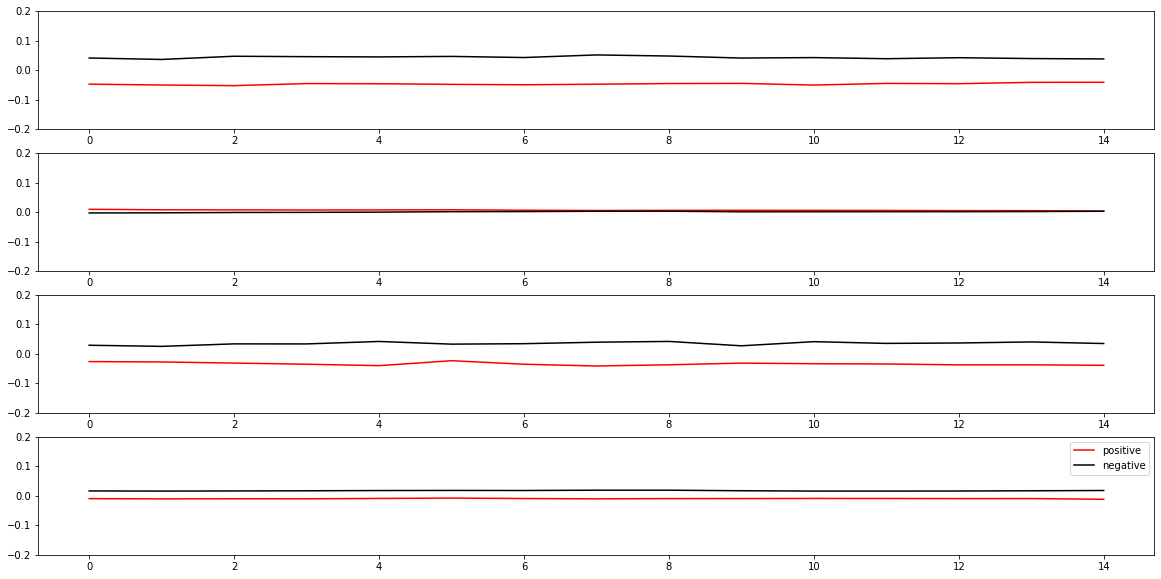

In [140]:
fig_limits = (-0.2,+0.2)
plt.figure(figsize=(20, 10))
plt.figure(1)
plt.subplot(411)
plt.plot(positive_df[0], color='red', label='positive')
plt.plot(negative_df[0], color='black', label='negative')
plt.ylim(fig_limits[0], fig_limits[1])
plt.subplot(412)
plt.plot(positive_df[1], color='red', label='positive')
plt.plot(negative_df[1], color='black', label='negative')
plt.ylim(fig_limits[0], fig_limits[1])
plt.subplot(413)
plt.plot(positive_df[2], color='red', label='positive')
plt.plot(negative_df[2], color='black', label='negative')
plt.ylim(fig_limits[0], fig_limits[1])
plt.subplot(414)
plt.plot(positive_df[3], color='red', label='positive')
plt.plot(negative_df[3], color='black', label='negative')
plt.ylim(fig_limits[0], fig_limits[1])
plt.legend()
_ = plt.plot()

for idx in range(4):
  print(f"[POS][Col {idx}]: {positive_df[idx].mean():.3f}+{positive_df[idx].std():.3f}")
  print(f"[NEG][Col {idx}]: {negative_df[idx].mean():.3f}+{negative_df[idx].std():.3f}")
  print("")

# Defining evolution parameters

register operands

In [0]:
def activation(a):
    return np.tanh(a)


def neg(a):
    return -a


def double(a):
    return 2.0 * a


def half(a):
    return 0.5 * a

def div0( a, b ):
  if np.isscalar(b):
    if b == 0.0:
      return a
    else:
      return a / b
  else:
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

In [0]:
pset = gp.PrimitiveSet("MAIN", 4, "IN")
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div0, 2)
pset.addPrimitive(np.fmax, 2)
pset.addPrimitive(np.square, 1)
pset.addPrimitive(neg, 1)
pset.addPrimitive(double, 1)
pset.addPrimitive(half, 1)
pset.addPrimitive(activation, 1)
pset.addTerminal(np.float64(1.0))
pset.addTerminal(np.float64(0.25))
pset.addTerminal(np.float64(0.5))
pset.addTerminal(np.float64(2.0))
pset.addTerminal(np.float64(3.0))

Support functions

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

In [0]:
def individual_to_function(individual):
    return toolbox.compile(expr=individual)

def convert_data(X,func):
  model_X = func(X[:, :, 0], X[:, :, 1], X[:, :, 2], X[:, :, 3])
  model_X = np.clip(model_X, -100, +100)
  if np.isscalar(model_X):
    model_X = np.full(X.shape[:2], model_X)
  return model_X


def train_creature(X, y, func):
    model_X = convert_data(X, func)
    clf =  DecisionTreeClassifier(max_depth=5)
    # oclf =  SGDClassifier(max_iter=1000, tol=1e-3), verbose=0
    _ = clf.fit(model_X, y)
    return clf


def predict_creatute(X, clf, func):
    model_X = convert_data(X, func)
    y_pred = clf.predict(model_X)
    return y_pred


def train_and_predict(X_train, y_train, X_predict, func):
    clf = train_creature(X_train, y_train, func)
    y_pred = predict_creatute(X_predict, clf, func)
    return y_pred


def fitness_function(individual):
    global evaluation_counter
    evaluation_counter += 1

    dynamic_train_idx = np.random.choice(X_train.shape[0], size=10000)
    dynamic_vld_idx = np.random.choice(X_train.shape[0], size=2000)
    dynamic_X_train = X_train[dynamic_train_idx, :, :]
    dynamic_y_train = y_train.loc[dynamic_train_idx, 1]
    dynamic_X_vld = X_train[dynamic_vld_idx, :, :]
    dynamic_y_vld = y_train.loc[dynamic_vld_idx, 1]

    func = individual_to_function(individual)
    y_pred = train_and_predict(dynamic_X_train, dynamic_y_train, dynamic_X_vld, func)
    if np.unique(y_pred).shape[0] < 2:
        # All elemetns are identical
        return 0.0,
    else:
        # Fitness is accuracy
        fitness_score = accuracy_score(dynamic_y_vld, y_pred)
        # Fitness is F0.25 score
        # fitness_score = fbeta_score(dynamic_y_vld, y_pred, beta=0.25)
        return fitness_score,

In [0]:
calculations_time = datetime.now()
global_time = datetime.now()

def calc_time(*args):
    global calculations_time
    now = datetime.now()
    result_time = now - calculations_time
    calculations_time = now
    return result_time

def calc_global_time(*args):
    global global_time
    now = datetime.now()
    result_time = now - global_time
    return result_time

Register hyper parameters

In [0]:
# random.seed(10)
population_size = 80
number_of_generations = 200
mutation_pb = 0.15
mate_pb = 0.8

In [147]:
history = History()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=2, max_=8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", fitness_function)
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=0, max_=15)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Bloat control
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("max", np.max)
stats.register("TIME", calc_time)
stats.register("GLOBAL", calc_global_time)

# Decorate the variation operators
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)
history.update(pop)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


# Evolve

In [0]:
verbose = True
evaluation_counter = 0
start_time = datetime.now()
calculations_time = datetime.now()

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in pop]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

if hof is not None:
    hof.update(pop)

# Begin the generational process
if colab_mode:
  loading_bar = tqdm.tqdm_notebook(range(1, number_of_generations + 1),desc='Evolving',total=number_of_generations)
else:
  loading_bar = range(1, number_of_generations + 1)

record = stats.compile(pop) if stats else {}
logbook.record(gen=0, nevals=len(invalid_ind), **record)
if verbose:
    msg = f'{logbook.stream}\t\t{0 :>.1f}%'
    print(msg)

for gen in loading_bar:
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))

    # Vary the pool of individuals
    offspring = varAnd(offspring, toolbox, mate_pb, mutation_pb)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    if hof is not None:
        hof.update(offspring)

    # Replace the current population by the offspring
    pop[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    if verbose:
        msg = f'{logbook.stream}\t\t{100 * gen/float(number_of_generations):>.1f}%'
        print(msg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


gen	nevals	avg     	std     	max  	TIME          	GLOBAL        
0  	80    	0.459556	0.174103	0.559	0:00:06.357344	0:00:06.476311		0.0%
1  	80    	0.488038	0.139616	0.56 	0:00:06.330319	0:00:12.806640		0.5%
2  	80    	0.510944	0.102009	0.5595	0:00:06.465638	0:00:19.272274		1.0%
3  	80    	0.522663	0.0603047	0.554 	0:00:07.056299	0:00:26.328575		1.5%
4  	80    	0.504606	0.116368 	0.561 	0:00:06.996968	0:00:33.325551		2.0%
5  	80    	0.518131	0.0845434	0.558 	0:00:06.911244	0:00:40.236785		2.5%
6  	80    	0.493894	0.141049 	0.5595	0:00:06.730873	0:00:46.967657		3.0%
7  	80    	0.506719	0.116932 	0.5675	0:00:07.100523	0:00:54.068181		3.5%
8  	80    	0.495119	0.141504 	0.556 	0:00:06.879666	0:01:00.947861		4.0%
9  	80    	0.498   	0.142158 	0.562 	0:00:06.700423	0:01:07.648269		4.5%
10 	80    	0.515425	0.102758 	0.567 	0:00:07.064818	0:01:14.713087		5.0%
11 	80    	0.50705 	0.116852 	0.5565	0:00:06.797948	0:01:21.511035		5.5%
12 	80    	0.509669	0.117468 	0.557 	0:00:07.031765	0:01:28.5428

# Results

In [0]:
record = stats.compile(pop)
duration = datetime.now() - start_time
print("Run concluded.")
print("Evaluations commited: {}".format(evaluation_counter))
print("Run time: {}".format(duration))
winner_creature = hof.items[0]
winner_function = individual_to_function(winner_creature)
print(f"Winner:\n{winner_creature}")

In [0]:
nodes, edges, labels = gp.graph(winner_creature)

In [0]:
if colab_mode:
  import matplotlib.pyplot as plt
  import networkx as nx
  from networkx.drawing.nx_agraph import graphviz_layout

  plt.rcParams["figure.figsize"] = (50, 40)

  g = nx.Graph()
  g.add_nodes_from(nodes)
  g.add_edges_from(edges)
  pos = graphviz_layout(g, prog="dot")


  nx.draw_networkx_nodes(g, pos, node_size=1600)
  nx.draw_networkx_edges(g, pos)
  nx.draw_networkx_labels(g, pos, labels, font_size=25)
  plt.show()

analyze and display

In [0]:
generations_idx = logbook.select('gen')
generations_avg = logbook.select('avg')
generations_std = logbook.select('std')
generations_max = logbook.select('max')
generations_min = logbook.select('min')

plt.figure(figsize=(20, 10))
plt.errorbar(generations_idx, generations_avg, yerr=generations_std, fmt='-o', label='AVG')
# plt.plot(generations_idx,generations_avg, '-o',label='AVG')
plt.plot(generations_max, '-o', label='BEST', color='black')
plt.plot(generations_min, '-o', label='WORST', color='red')
plt.grid()
plt.legend()
plt.xlabel('Generations')
plt.ylabel('hits')
plt.ylim(0, 1)
if colab_mode:
  _ = plt.plot()
else:
  plt.savefig("Evolution.png")

Evaluate winner on entire train-set

In [0]:
predictions = train_and_predict(X_train, y_train[1], X_train, winner_function)
true_results = y_train[1]

scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy', 'value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall', 'value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision', 'value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25', 'value'] = fbeta_score(true_results, predictions, beta=0.25)

print("Labels balance:")
print("0: {:>.3f}".format(1 - predictions.mean()))
print("1: {:>.3f}".format(predictions.mean()))
display(scoring_sr)

Evaluate winner on VLD group

In [0]:
predictions = train_and_predict(X_train, y_train[1], X_vld, winner_function)
true_results = y_vld[1]

scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy', 'value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall', 'value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision', 'value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25', 'value'] = fbeta_score(true_results, predictions, beta=0.25)

print("Labels balance:")
print("0: {:>.3f}".format(1 - predictions.mean()))
print("1: {:>.3f}".format(predictions.mean()))

display(scoring_sr)

Store results

In [0]:
import pickle
outfile = 'creature.p'

if not colab_mode:
  print(f"exporting to drive at: {outpath}")
  with open(outfile, 'wb') as ffile:
    pickle.dump(winner_creature, ffile)
else:
  from google.colab import drive

  base_folder = r'/content/drive/My Drive/colab_storage'
  outpath = os.path.join(base_folder ,outfile)
  print(f"exporting to drive at: {outpath}")
  with open(outpath, 'wb') as ffile:
    pickle.dump(winner_creature, ffile)

# LSTM part

Create adjusted data

In [0]:
def adjust_to_lstm(X):
    return X.reshape(X.shape[0], window_size, 1)

In [0]:
X_train_nn = adjust_to_lstm(convert_data(X_train, winner_function))
X_vld_nn = adjust_to_lstm(convert_data(X_vld, winner_function))
X_test_nn = adjust_to_lstm(convert_data(X_test, winner_function))

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras

import random
import io
import re
import tqdm

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fbeta(y_true, y_pred):
  beta = 0.25
  beta_sq = beta ** 2
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return (1 + beta_sq) * ((precision*recall)/((beta_sq * precision)+recall+K.epsilon()))

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
overfitCallback = EarlyStopping(monitor='loss',
                                min_delta=0.001, patience = 25,
                                mode='auto')

In [0]:
print('Build model...')
model = Sequential()
input_layer = Input(shape=(window_size, 1))
model.add(input_layer)
lstm = LSTM(128, activation='relu')
model.add(lstm)
model.add(Dropout(0.13))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(2, activation='softmax'))


# optimizer = RMSprop(lr=0.01)
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

Train

In [0]:
batch_size = 2048 * 8
epocs = 600
print("Fitting hyperparameters:")
print(f"X-Train shape: {X_train_nn.shape}")
print(f"y-Train shape: {y_train.shape}")
print(f"X-Validation shape: {X_vld_nn.shape}")
print(f"y-Validation shape: {y_vld.shape}")
print(f"batch_size: {batch_size}\tEpocs: {epocs}")

history = model.fit(x=X_train_nn,y=y_train, validation_data=(X_vld_nn,y_vld),
                    batch_size=batch_size,epochs=epocs, validation_freq=1,
                    callbacks=[]
                    )

# Plot training & validation accuracy values
acc = [acc for acc in history.history.keys() if 'acc' in acc and 'val' not in acc][0]
val_acc = [acc for acc in history.history.keys() if 'acc' in acc and 'val' in acc][0]
plt.plot(history.history[acc])
plt.plot(history.history[val_acc])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
if colab_mode:
    plt.show()
else:
    plt.savefig("NN Accuracy History.png")

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
if colab_mode:
    plt.show()
else:
    plt.savefig("NN LOSS History.png")

optimize decision boundry

In [0]:
import scipy.optimize as optimize

predictions_prob = model.predict(X_train_nn)[:,1]
true_results = y_train.to_numpy().argmax(axis=1)

def best_threshold(thrsh_mat):
    thrsh = thrsh_mat[0]
    prediction_t = (predictions_prob > thrsh).astype(int)
    score = - fbeta_score(true_results, prediction_t, beta=0.25)
    return score
options = {'disp': False}


ret = optimize.minimize(best_threshold, 0.5, method='COBYLA',
                        options=options)
thrsh = ret['x']
f_score =  - ret['fun']

print(f"Chosen trshold: {thrsh :>.3f}")
print(f"Expected fscore: {f_score:>.3f}")

Check on train

In [0]:
predictions = (model.predict(X_train_nn)[:,1] > thrsh).astype(int)
true_results = y_train.to_numpy().argmax(axis=1)

scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy', 'value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall', 'value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision', 'value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25', 'value'] = fbeta_score(true_results, predictions, beta=0.25)

print("Labels balance on TRAIN:")
print("0: {:>.3f}".format(1 - predictions.mean()))
print("1: {:>.3f}".format(predictions.mean()))
display(scoring_sr)

Check on VLD

In [0]:
predictions = (model.predict(X_vld_nn)[:,1] > thrsh).astype(int)
true_results = y_vld.to_numpy().argmax(axis=1)

scoring_sr = pd.DataFrame(dtype=np.float, columns=['value'])
scoring_sr.loc['Accuracy', 'value'] = accuracy_score(true_results, predictions)
scoring_sr.loc['Recall', 'value'] = recall_score(true_results, predictions)
scoring_sr.loc['precision', 'value'] = precision_score(true_results, predictions)
scoring_sr.loc['F0.25', 'value'] = fbeta_score(true_results, predictions, beta=0.25)

print("Labels balance on TRAIN:")
print("0: {:>.3f}".format(1 - predictions.mean()))
print("1: {:>.3f}".format(predictions.mean()))
display(scoring_sr)

Generate test results

In [0]:
test_predictions = (model.predict(X_test_nn)[:,1] > thrsh).astype(int)
display(test_predictions)

Export output

In [0]:
outfile = 'results.txt'

if not colab_mode:
  base_folder = os.path.dirname(__file__)
  outpath = os.path.join(base_folder, outfile)
  print(f"exporting to drive at: {outpath}")
  with open(outpath, 'w') as ffile:
    np.savetxt(ffile,test_predictions,fmt='%i')
else:
  from google.colab import drive

  base_folder = r'/content/drive/My Drive/colab_storage'
  outpath = os.path.join(base_folder ,outfile)
  print(f"exporting to drive at: {outpath}")
  with open(outpath, 'w') as ffile:
    np.savetxt(ffile,test_predictions,fmt='%i')